<a href="https://colab.research.google.com/github/jdasam/ant5015/blob/main/notebooks/14th_week_nsynth_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchaudio
from pathlib import Path
import pandas as pd
import IPython.display as ipd
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
'''
Let's only use testset
'''
!wget http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz

--2024-06-03 05:00:58--  http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz
Resolving download.magenta.tensorflow.org (download.magenta.tensorflow.org)... 173.194.213.207, 173.194.215.207, 173.194.216.207, ...
Connecting to download.magenta.tensorflow.org (download.magenta.tensorflow.org)|173.194.213.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 349501546 (333M) [application/gzip]
Saving to: ‘nsynth-test.jsonwav.tar.gz’

nsynth-test.jsonwav 100%[===================>] 333.31M   191MB/s    in 1.7s    

2024-06-03 05:01:00 (191 MB/s) - ‘nsynth-test.jsonwav.tar.gz’ saved [349501546/349501546]



In [3]:
!tar -xf nsynth-test.jsonwav.tar.gz

In [4]:
class NSynthDataSet:
  def __init__(self, path):
    if isinstance(path, str):
      path = Path(path)
    self.path = path
    json_path = path / "examples.json"
    # self.meta = pd.read_json(json_path).to_dict()
    self.meta= pd.read_json(json_path)
    self.file_list = list(self.path.rglob('*.wav'))

  def __getitem__(self, idx):
    fn = self.file_list[idx]
    audio, sr = torchaudio.load(fn)
    pitch = self.meta[fn.stem]['pitch']
    pitch = torch.tensor(pitch, dtype=torch.long)
    return audio, pitch

  def __len__(self):
    return len(self.meta.keys())

dataset = NSynthDataSet(Path('nsynth-test'))


In [7]:
audio, pitch = dataset[10]
ipd.Audio(audio, rate=16000)

In [10]:
train_loader = DataLoader(dataset, batch_size=2, shuffle=True)
# test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)
batch = next(iter(train_loader))
audio, pitch = batch


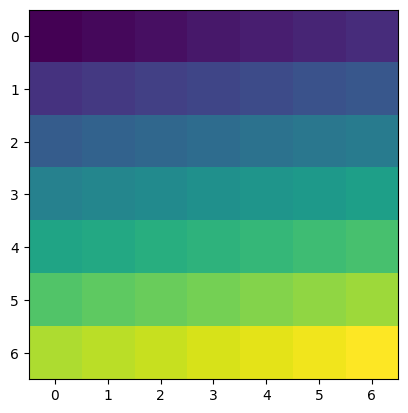

In [26]:
dummy = torch.arange(49).view(1, 1, 7,7).to(torch.float)
plt.imshow(dummy[0,0])

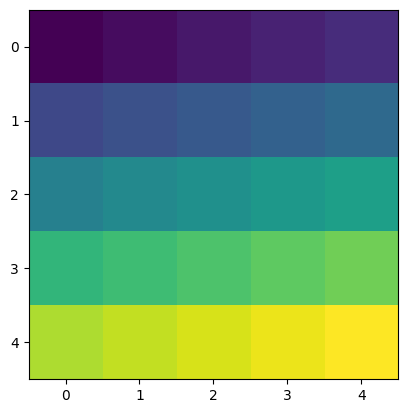

In [37]:
kernel_size = 3
stride = 1
padding = 0

conv_layer = nn.Conv2d(1, 1, kernel_size, stride=stride, padding=padding)
conv_layer.weight.data = torch.ones_like(conv_layer.weight)
conv_out = conv_layer(dummy)
plt.imshow(conv_out.squeeze().detach())

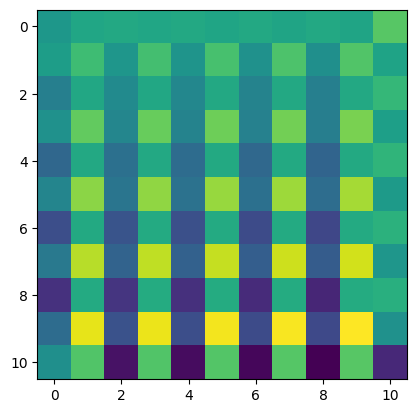

In [47]:
padding = 0
stride = 2

transpose_layer = nn.ConvTranspose2d(1, 1, kernel_size=kernel_size, stride=stride, padding=padding)
# transpose_layer.weight.data = torch.ones_like(transpose_layer.weight.data)

t_out = transpose_layer(conv_out)
plt.imshow(t_out.squeeze().detach())

## NSynth Autoencoder

In [49]:
class SpecModel(nn.Module):
  def __init__(self, n_fft, hop_length):
    super().__init__()
    self.spec_converter = torchaudio.transforms.Spectrogram(n_fft=n_fft, hop_length=hop_length)
    self.db_converter = torchaudio.transforms.AmplitudeToDB(stype='power')

  def forward(self, audio_sample):
    spec = self.spec_converter(audio_sample)
    db_spec = self.db_converter(spec)
    return db_spec

class Conv2dNormPool(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, padding, stride):
    super().__init__()
    self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, stride=stride)
    self.batch_norm = nn.BatchNorm2d(out_channels)
    self.activation = nn.LeakyReLU(0.1)

  def forward(self, x):
    x = self.conv(x)
    x = self.batch_norm(x)
    x = self.activation(x)
    return x

class Conv2dNormTransposePool(Conv2dNormPool):
  def __init__(self, in_channels, out_channels, kernel_size, padding, stride):
    super().__init__(in_channels, out_channels, kernel_size, padding, stride)
    self.conv = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, stride=stride)


class AutoEncoder(nn.Module):
  def __init__(self, n_fft, hop_length, hidden_size=256):
    super().__init__()
    self.spec_model = SpecModel(n_fft, hop_length)
    self.encoder = nn.Sequential()
    self.pitch_embedder = nn.Embedding(121, hidden_size//2)
    self.num_channels = [1] + [128] * 3 + [256] * 3 + [512] * 2 + [1024]
    i = 0
    self.encoder.add_module(f"conv_norm{i}", Conv2dNormPool(self.num_channels[i], self.num_channels[i+1], (5,5), 2, (2,2) ))
    for i in range(1,7):
      self.encoder.add_module(f"conv_norm{i}", Conv2dNormPool(self.num_channels[i], self.num_channels[i+1], (4,4), 1, (2,2) ))
    i = 7
    self.encoder.add_module(f"conv_norm{i}", Conv2dNormPool(self.num_channels[i], self.num_channels[i+1], (2,2), 0, (2,2) ))
    i = 8
    self.encoder.add_module(f"conv_norm{i}", Conv2dNormPool(self.num_channels[i], self.num_channels[i+1], (1,1), 0, (1,1) ))
    self.final_layer = nn.Linear(hidden_size * 2, hidden_size)
    self.decoder = nn.Sequential(
        Conv2dNormTransposePool(in_channels=self.num_channels[-1] + hidden_size//2, out_channels=self.num_channels[-2], kernel_size=(2,1), padding=0, stride=(2,2))
    )
    i = 0
    self.decoder.add_module(f"conv_norm{i}", Conv2dNormTransposePool(self.num_channels[-2-i], self.num_channels[-3-i], (2,2), 0, (2,2)))
    for i in range(1,7):
      self.decoder.add_module(f"conv_norm{i}", Conv2dNormTransposePool(self.num_channels[-2-i], self.num_channels[-3-i], (4,4), 1, (2,2)))
    self.decoder.add_module("final_module",  nn.ConvTranspose2d(in_channels=self.num_channels[1], out_channels=1, kernel_size=(4,4), padding=1, stride=(2,2)),)


  def forward(self, x, pitch):
    # run encoder

    # run decoder


    spec = self.spec_model(x)
    spec = spec[:,:,:-1] # to match 512
    spec /= 80
    spec = nn.functional.pad(spec, (2,3), value=torch.min(spec))
    out = self.encoder(spec)

    latent = self.final_layer(out.view(out.shape[0], -1))
    latent = torch.cat([latent, self.pitch_embedder(pitch)], dim=-1)
    latent = latent.view(latent.shape[0], -1, 1, 1)
    recon_spec = self.decoder(latent)
    return recon_spec, spec

model = AutoEncoder(1024, 256, 1024)
recon_spec, spec = model(audio, pitch)
recon_spec.shape, spec.shape

(torch.Size([2, 1, 512, 256]), torch.Size([2, 1, 512, 256]))

### Model forward

In [20]:
x = audio
self = model
print(f"audio shape: {x.shape}")

spec = self.spec_model(x)
print(f"spec shape:{spec.shape}")

# drop last frequency frame
spec = spec[:,:,:-1] # to match 512
print(f"spec shape:{spec.shape}")
print(f"spec meidan:{torch.median(spec)}")
spec /= 80
print(f"spec meidan:{torch.median(spec)}")
spec = nn.functional.pad(spec, (2,3), value=torch.min(spec))
print(f"spec shape:{spec.shape}")

encoder_out = model.encoder(spec)
print(f"encoder_out shape:{encoder_out.shape}")
latent = self.final_layer(encoder_out.flatten(1))
print(f"latent shape:{latent.shape}")


audio shape: torch.Size([2, 1, 64000])
spec shape:torch.Size([2, 1, 513, 251])
spec shape:torch.Size([2, 1, 512, 251])
spec meidan:-68.6930923461914
spec meidan:-0.8586636781692505
spec shape:torch.Size([2, 1, 512, 256])
encoder_out shape:torch.Size([2, 1024, 2, 1])
latent shape:torch.Size([2, 1024])


In [48]:
model.decoder

Sequential(
  (0): Conv2dNormTransposePool(
    (conv): ConvTranspose2d(1536, 512, kernel_size=(2, 1), stride=(2, 2))
    (batch_norm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): LeakyReLU(negative_slope=0.1)
  )
  (conv_norm0): Conv2dNormTransposePool(
    (conv): ConvTranspose2d(512, 512, kernel_size=(2, 2), stride=(2, 2))
    (batch_norm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): LeakyReLU(negative_slope=0.1)
  )
  (conv_norm1): Conv2dNormTransposePool(
    (conv): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): LeakyReLU(negative_slope=0.1)
  )
  (conv_norm2): Conv2dNormTransposePool(
    (conv): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=

## Download pretrained model
- The model was trained about 1800k iterations with entire training set

In [51]:
!gdown 13it0VrccbE5QkdEGTlHZjSQFZLZTy1uu

Downloading...
From (original): https://drive.google.com/uc?id=13it0VrccbE5QkdEGTlHZjSQFZLZTy1uu
From (redirected): https://drive.google.com/uc?id=13it0VrccbE5QkdEGTlHZjSQFZLZTy1uu&confirm=t&uuid=29dee6ae-d2cd-4382-b32a-8adc6109335d
To: /content/autoencoder_last.pt
100% 67.5M/67.5M [00:01<00:00, 47.0MB/s]


In [ ]:
pretrained_weights = torch.load('autoencoder_last.pt', map_location='cpu')
model.load_state_dict(pretrained_weights)
model.eval()

In [110]:
ipd.Audio(audio[1], rate=16000)

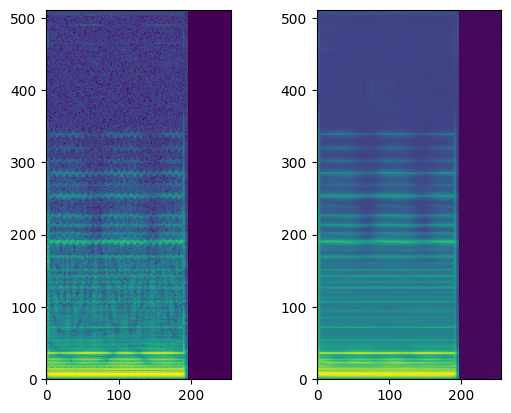

In [109]:
audio, pitch = batch

with torch.no_grad():
  recon_spec, spec = model(audio, pitch)

plt.subplot(1,2,1)
plt.imshow(spec[1, 0], origin='lower', interpolation='nearest')
plt.subplot(1,2,2)
plt.imshow(recon_spec[1, 0], origin='lower', interpolation='nearest')

In [ ]:
test_loader = DataLoader(dataset, batch_size=64, num_workers=4,pin_memory=True)
test_batch = next(iter(test_loader))

### Convert Spectrogram to Wav using Griffin-Lim Algorithm
- The model is trained to generate magnitude spectrogram, so we need to convert it to wav file using Griffin-Lim Algorithm
- Griffin-Lim Algorithm is an iterative algorithm to estimate phase information from magnitude spectrogram

In [66]:
def network_output_to_audio(spec):
  rescaled_spec = spec * 80
  padded_spec = nn.functional.pad(rescaled_spec, (0,0, 0,1), value=-100)
  magnitude_spec = torchaudio.functional.DB_to_amplitude(padded_spec, ref=1, power=1)
  griffin_lim = torchaudio.transforms.GriffinLim(n_fft=1024, hop_length=256, n_iter=100)
  spec_recon_audio = griffin_lim(magnitude_spec)

  return spec_recon_audio


org_audio = network_output_to_audio(spec[1])
ipd.Audio(org_audio, rate=16000)

In [68]:
recon_audio = network_output_to_audio(recon_spec[1])
ipd.Audio(recon_audio, rate=16000)

In [113]:
audio, pitch = next(iter(train_loader))
ipd.display(ipd.Audio(audio[0], rate=16000))
ipd.display(ipd.Audio(audio[1], rate=16000))


In [76]:
pitch += 1
with torch.no_grad():
  recon_spec, spec = model(audio, pitch)

recon_audio = network_output_to_audio(recon_spec[0])
ipd.Audio(recon_audio, rate=16000)

In [117]:
ipd.display(ipd.Audio(audio[0], rate=16000))
ipd.display(ipd.Audio(audio[1], rate=16000))


In [129]:
recon_spec, _ = model(audio, pitch)
recon_audio = network_output_to_audio(recon_spec)
ipd.Audio(recon_audio.detach()[1], rate=16000)

In [139]:
def get_latent(self, audio):
  spec = self.spec_model(audio)
  spec = spec[:,:,:-1] # to match 512
  spec /= 80
  spec = nn.functional.pad(spec, (2,3), value=torch.min(spec))
  out = self.encoder(spec)

  latent = self.final_layer(out.view(out.shape[0], -1))
  return latent

latent_vectors = get_latent(model, audio)
vector_a = latent_vectors[0]
vector_b = latent_vectors[1]

mean_latent_vector = (vector_a * 3 + vector_b * 1) / 4
# mean_latent_vector.shape

In [140]:
def latent_to_spec(self, latent, pitch):
  latent = torch.cat([latent, self.pitch_embedder(pitch)], dim=-1)
  latent = latent.view(latent.shape[0], -1, 1, 1)
  print(latent.shape)
  recon_spec = self.decoder(latent)
  return recon_spec

recon_spec = latent_to_spec(model, mean_latent_vector.unsqueeze(0), pitch[1:])
recon_audio = network_output_to_audio(recon_spec)
ipd.Audio(recon_audio.detach()[0], rate=16000)

torch.Size([1, 1536, 1, 1])


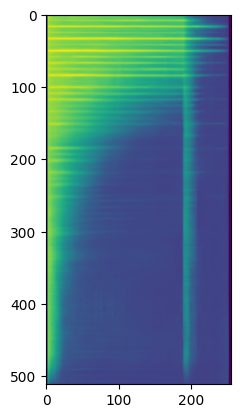

In [125]:
plt.imshow(recon_spec[0, 0].detach())